# Project 2 - SAT & Poverty Analysis (NYC 2012)

**Robin Zhao**

Data Source: 

https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j/about_data

https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4/about_data


I chose 2012 SAT Results Dataset and 2006–2012 School Demographics and Accountability Snapshot. The first dataset provides school-level SAT performance for New York City public high schools in 2012. It includes each school's DBN, school name, the number of test takers, and the average scores for the three SAT sections. The second dataset contains annual demographic, enrollment, and student-need indicators for NYC public shcools from 2006 to 2012. Each record is identified by DBN and school year. For this project, I will only use the 2011-2012 school year to match the timing of the SAT dataset.

My research question is "How does socioeconomic disadvantage, which measured by the percentage of students eligible for free or reduced-price lunch, relate to SAT performance across New York City high schools in 2012?"

In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt



sat = pd.read_csv('2012_sat_scores.csv')
demo = pd.read_csv('sat_demographics.csv')

sat.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


In [2]:
demo.head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,...,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,...,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,NaN,261,18,43,39,36,...,77,29.5,157,60.2,7,2.7,143.0,54.8,118.0,45.2
3,01M015,P.S. 015 ROBERTO CLEMENTE,20082009,89.4,NaN,252,17,37,44,32,...,75,29.8,149,59.1,7,2.8,149.0,59.1,103.0,40.9
4,01M015,P.S. 015 ROBERTO CLEMENTE,20092010,,96.5,208,16,40,28,32,...,67,32.2,118,56.7,6,2.9,124.0,59.6,84.0,40.4


In [3]:
#step 1: Cleaning the Data
sat_clean = sat.copy() #create a copy of the original dataset
sat_clean = sat_clean.rename(columns={
    'SCHOOL NAME': 'school_name',
    'DBN': 'dbn',
    'SAT Critical Reading Avg. Score': 'sat_read',
    'SAT Math Avg. Score': 'sat_math',
    'SAT Writing Avg. Score': 'sat_write'
})

score_cols = ['sat_read', 'sat_math', 'sat_write']
for col in score_cols:
    sat_clean[col] = pd.to_numeric(sat_clean[col], errors='coerce')

sat_clean['sat_total'] = sat_clean[score_cols].sum(axis=1)
sat_clean = sat_clean.dropna(subset=['sat_total'])

sat_clean.info()
sat_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   dbn                     478 non-null    object 
 1   school_name             478 non-null    object 
 2   Num of SAT Test Takers  478 non-null    object 
 3   sat_read                421 non-null    float64
 4   sat_math                421 non-null    float64
 5   sat_write               421 non-null    float64
 6   sat_total               478 non-null    float64
dtypes: float64(4), object(3)
memory usage: 26.3+ KB


,dbn,school_name,Num of SAT Test Takers,sat_read,sat_math,sat_write,sat_total
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0
3,01M458,FORSYTH SATELLITE ACADEMY,7,414.0,401.0,359.0,1174.0
4,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0


In [4]:
#Step 1: Cleaning the Data
demo_clean = demo[demo['schoolyear'] == 20112012].copy()
demo_clean = demo_clean.rename(columns={
    'DBN': 'dbn',
})
demo_clean['frl_percent'] = pd.to_numeric(demo_clean['frl_percent'], errors='coerce')
demo_clean = demo_clean.dropna(subset=['frl_percent']) #remove rows with missing frl_percent

demo_clean.info()
demo_clean.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1509 entries, 6 to 10074
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dbn                1509 non-null   object 
 1   Name               1509 non-null   object 
 2   schoolyear         1509 non-null   int64  
 3   fl_percent         0 non-null      object 
 4   frl_percent        1509 non-null   float64
 5   total_enrollment   1509 non-null   int64  
 6   prek               1509 non-null   object 
 7   k                  1509 non-null   object 
 8   grade1             1509 non-null   object 
 9   grade2             1509 non-null   object 
 10  grade3             1509 non-null   object 
 11  grade4             1509 non-null   object 
 12  grade5             1509 non-null   object 
 13  grade6             1509 non-null   object 
 14  grade7             1509 non-null   object 
 15  grade8             1509 non-null   object 
 16  grade9             1509 non-

,dbn,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
6,01M015,P.S. 015 ROBERTO CLEMENTE,20112012,NaN,89.4,189,13,31,35,28,...,63,33.3,109,57.7,4,2.1,97.0,51.3,92.0,48.7
13,01M019,P.S. 019 ASHER LEVY,20112012,NaN,61.5,328,32,46,52,54,...,81,24.7,158,48.2,28,8.5,147.0,44.8,181.0,55.2
20,01M020,PS 020 ANNA SILVER,20112012,NaN,92.5,626,52,102,121,87,...,55,8.8,357,57.0,16,2.6,330.0,52.7,296.0,47.3
27,01M034,PS 034 FRANKLIN D ROOSEVELT,20112012,NaN,99.7,401,14,34,38,36,...,90,22.4,275,68.6,8,2.0,204.0,50.9,197.0,49.1
35,01M063,PS 063 WILLIAM MCKINLEY,20112012,NaN,78.9,176,18,20,30,21,...,41,23.3,110,62.5,15,8.5,97.0,55.1,79.0,44.9


In [5]:
# Step 2: Merging the Datasets
merged = pd.merge(sat_clean, demo_clean, on='dbn', how='inner')
merged.info()
merged.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   dbn                     450 non-null    object 
 1   school_name             450 non-null    object 
 2   Num of SAT Test Takers  450 non-null    object 
 3   sat_read                412 non-null    float64
 4   sat_math                412 non-null    float64
 5   sat_write               412 non-null    float64
 6   sat_total               450 non-null    float64
 7   Name                    450 non-null    object 
 8   schoolyear              450 non-null    int64  
 9   fl_percent              0 non-null      object 
 10  frl_percent             450 non-null    float64
 11  total_enrollment        450 non-null    int64  
 12  prek                    450 non-null    object 
 13  k                       450 non-null    object 
 14  grade1                  450 non-null    ob

,dbn,school_name,Num of SAT Test Takers,sat_read,sat_math,sat_write,sat_total,Name,schoolyear,fl_percent,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,20112012,NaN,...,123,29.1,227,53.8,7,1.7,259.0,61.4,163.0,38.6
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,20112012,NaN,...,89,22.6,181,45.9,9,2.3,226.0,57.4,168.0,42.6
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HIGH SCHOOL,20112012,NaN,...,143,23.9,331,55.4,62,10.4,327.0,54.7,271.0,45.3
3,01M458,FORSYTH SATELLITE ACADEMY,7,414.0,401.0,359.0,1174.0,SATELLITE ACADEMY HS @ FORSYTHE STREET,20112012,NaN,...,77,34.4,133,59.4,8,3.6,97.0,43.3,127.0,56.7
4,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,MARTA VALLE SECONDARY SCHOOL,20112012,NaN,...,116,31.6,209,56.9,6,1.6,170.0,46.3,197.0,53.7


In [6]:
# Step 2: Final Cleaning
final = merged[['dbn', 'school_name', 'sat_total', 'frl_percent']].copy()
final.head()

,dbn,school_name,sat_total,frl_percent
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,1122.0,88.6
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,1172.0,71.8
2,01M450,EAST SIDE COMMUNITY SCHOOL,1149.0,71.8
3,01M458,FORSYTH SATELLITE ACADEMY,1174.0,72.8
4,01M509,MARTA VALLE HIGH SCHOOL,1207.0,80.7


In [7]:
import plotly.express as px
fig = px.scatter(
    final,
    x = 'frl_percent',
    y = 'sat_total',
    trendline = 'ols',
    opacity = 0.7,
    title = 'Relationship Between School Poverty and SAT Performance (NYC 2012)',
    labels = {
        'frl_percent': '% FRL (Poverty Indicator)',
        'sat_total': 'Total SAT Score'
    }

)
fig.show()


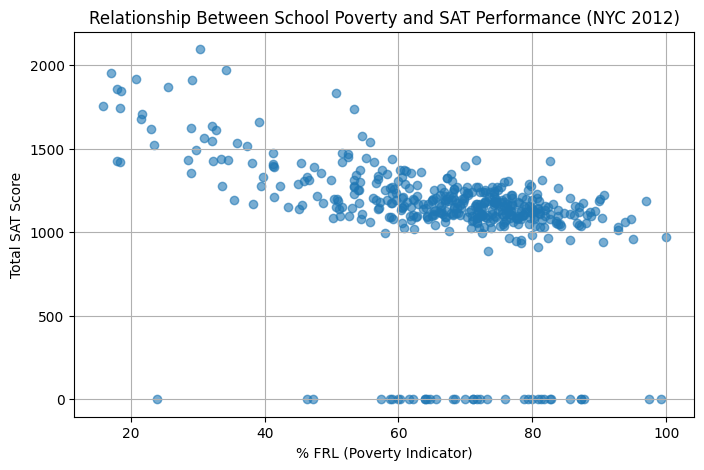

In [8]:
# Since the scatter plot does not show up in GitHub Pages, here is the code again to display it.
plt.figure(figsize=(8, 5))

plt.scatter(final['frl_percent'], final['sat_total'], alpha=0.6)

plt.xlabel('% FRL (Poverty Indicator)')
plt.ylabel('Total SAT Score')
plt.title('Relationship Between School Poverty and SAT Performance (NYC 2012)')

plt.grid(True)
plt.show()


## Key Findings
The scatter plot shows a clear negative relationship between school poverty (measured by the percentage of students eligible for free/reduced lunch) and SAT performance. Schools with higher FRL percentages tend to have lower total SAT scores.
## Outliers
There are some zero or extremely low SAT totals on the bottom edge. I think these points reflect reporting errors or missing SAT participants. However, these points do have effect on the fitted regression line because they are dragging the line downward.
## Final Thought
Despite the outliers, the overall trend remains strong. Higher poverty is consistently associated with lower SAT performance. But poverty is not the only factor affect SAT performance. A more detailed model (e.g., including school size or borough fixed effects) would help separate poverty effects from school-type differences.
